# Pytorch Lightning Framework for training S+Z Galaxy Classifiers

## Imports

In [1]:
import gc
from enum import Enum
import torch
import lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger,CSVLogger
import shap
from PIL import Image
import torchvision

from ChiralityClassifier import ChiralityClassifier
from dataset_utils import *
from metrics_utils import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


GZDESI/GZRings/GZCD not available from galaxy_datasets.pytorch.datasets - skipping


## Options

In [2]:
class datasets(Enum):
    FULL_DATASET = 0 #Use all 600,000 galaxies in GZ1 catalog
    CUT_DATASET = 1 #Use cut of 200,000 galaxies, with pre-selected test data and downsampled train data
    BEST_SUBSET = 2 #Select N best S,Z & other galaxies, evenly split
    LOCAL_SUBSET = 3 #Use local cache of 1500 galaxies
    FULL_DESI_DATASET = 4 #Use all 7 million galaxies in DESI catalog, minus those that appear in cut catalog (predict only)
    CUT_TEST_DATASET = 5 #The testing dataset from the CUT_DATASET (predict only)

class modes(Enum):
    TRAIN = 0 #Train on a dataset
    TEST = 1 #Test an existing saved model on a labelled dataset
    PREDICT = 2 #Use an existing saved model on an labelled/unlabelled dataset

DATASET = datasets.CUT_DATASET #Select which dataset to train on, or if testing/predicting, which dataset the model was trained on
RUN = 0

PREDICT_DATASET = datasets.LOCAL_SUBSET #If predicting, predict this dataset

# Models:
#resnet18,resnet34,resnet50,resnet101,resnet152,
#ce_resnet50,lenet,g_resnet18,g_resnet50,g_lenet,g_resnet18_old
MODEL_NAME = "resnet18"
CUSTOM_ID = ""

IMG_SIZE = 160 #This is the output size of the generated image array
NUM_WORKERS = 6 #Number of workers in dataloader (usually set to no of CPU cores - 1)
MAX_IMAGES = -1 #Max number of images to load (-1 for all)
FLIP_EQUIVARIANCE = False #Enable flip-equivariance (g_resnet models only)
CUSTOM_PREDICT = False #Use Jia et al (2023) flipped predict function (g_resnet models only)

#HYPERPARAMS
BATCH_SIZE = 30 #Number of images per batch
LEARNING_RATE = 0.0001
MAX_EPOCHS = 60

PATHS = dict(
    METRICS_PATH = "../Metrics",
    LOG_PATH = "../Code/lightning_logs",
    FULL_DATA_PATH =  "/share/nas2/walml/galaxy_zoo/decals/dr8/jpg",
    LOCAL_SUBSET_DATA_PATH =  "../Data/Subset",
    FULL_CATALOG_PATH =  "../Data/gz1_desi_cross_cat.csv",
    FULL_DESI_CATALOG_PATH =  "../Data/desi_full_cat.parquet",
    CUT_CATALOG_TEST_PATH =  "../Data/gz1_desi_cross_cat_testing.csv",
    CUT_CATALOG_TRAIN_PATH = "../Data/gz1_desi_cross_cat_train_val_downsample.csv",
    BEST_SUBSET_CATALOG_PATH =  "../Data/gz1_desi_cross_cat_best_subset.csv",
    LOCAL_SUBSET_CATALOG_PATH =  "../Data/gz1_desi_cross_cat_local_subset.csv",
)

torch.set_float32_matmul_precision("medium")
if len(CUSTOM_ID) == 0:
    MODEL_ID = f"{MODEL_NAME}_{DATASET.name.lower()}"
else:
     MODEL_ID = f"{MODEL_NAME}_{DATASET.name.lower()}_{CUSTOM_ID}"
print(f"********** Running model {MODEL_ID} in mode Shap ***********")

********** Running model resnet18_cut_dataset in mode Shap ***********


## Reading in data

In [3]:
device = get_device()
datamodule = generate_datamodule(PREDICT_DATASET,modes.PREDICT,PATHS,datasets,modes,IMG_SIZE,BATCH_SIZE,NUM_WORKERS,MAX_IMAGES)
datamodule.prepare_data()
datamodule.setup(stage='predict')

Using pytorch 2.2.1. CPU cores available on device: 8
Using device: cpu
Created 1499 galaxy filepaths


## Code to run

In [4]:
save_dir = f"{PATHS['METRICS_PATH']}/{MODEL_ID}/version_{RUN}"
MODEL_PATH = f"{save_dir}/model.pt"

model = ChiralityClassifier(
    num_classes=(2 if (MODEL_NAME=="ce_resnet50" or CUSTOM_PREDICT) else 3), #2 for Jia et al version
    model_version=MODEL_NAME,
    optimizer="adamw",
    scheduler  ="steplr",
    lr=LEARNING_RATE,
    weight_decay=0,
    step_size=5,
    gamma=0.85,
    weights=MODEL_PATH,
    graph_save_path=None,
    flip_eq=FLIP_EQUIVARIANCE,
    custom_predict = CUSTOM_PREDICT
)

In [8]:
def generate_shap_plot(image_index):
    X= datamodule.predict_dataset[image_index] #For predicting any specific index
    X = torch.Tensor(X).unsqueeze(0) #This is in format nchw

    # X = next(iter(datamodule.predict_dataloader())) #Use to load first batch
    # X = torch.Tensor(X) #This is in format nchw

    Xtr = nchw_to_nhwc(X) #This is in format nhwc

    prediction = torch.softmax(model(X),dim=1).detach().numpy()[0]
    class_names = [f'Clockwise Spiral ({prediction[0]:.1%})',f'Anticlockwise Spiral ({prediction[1]:.1%})',f'Other ({prediction[2]:.1%})']

    def pass_to_model(x):
        #This takes input in format nhwc
        x = torch.Tensor(x)
        if x.shape == [160, 160,3]: #Add n if missing
            x = x.unsqueeze(0)
        x = nhwc_to_nchw(x)
        return model(x) #Model takes nchw

    masker = shap.maskers.Image("blur(160,160)",Xtr[0].shape)
    explainer = shap.Explainer(pass_to_model, masker, output_names=class_names)
    shap_values = explainer(Xtr[0:1], max_evals=10000, batch_size=100, outputs=shap.Explanation.argsort.flip[:3])
    shap_values.data = shap_values.data.cpu().numpy()

    plt.figure(figsize=(6,10))
    shap.image_plot(shap_values,show=False)
    #plt.savefig(f"{PREDICT_DATASET.name.lower()}_{image_index}_shap.png")
    plt.show()

Partition explainer: 2it [04:35, 275.83s/it]              


<Figure size 600x1000 with 0 Axes>

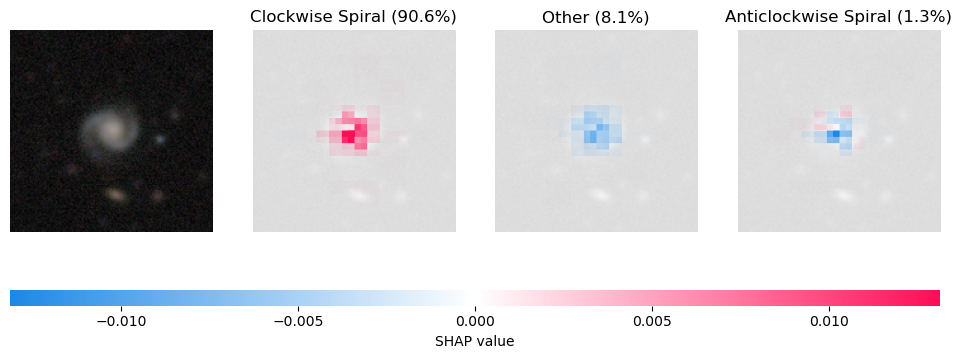

In [9]:
generate_shap_plot(2)

Partition explainer: 2it [05:24, 324.10s/it]              


<Figure size 600x1000 with 0 Axes>

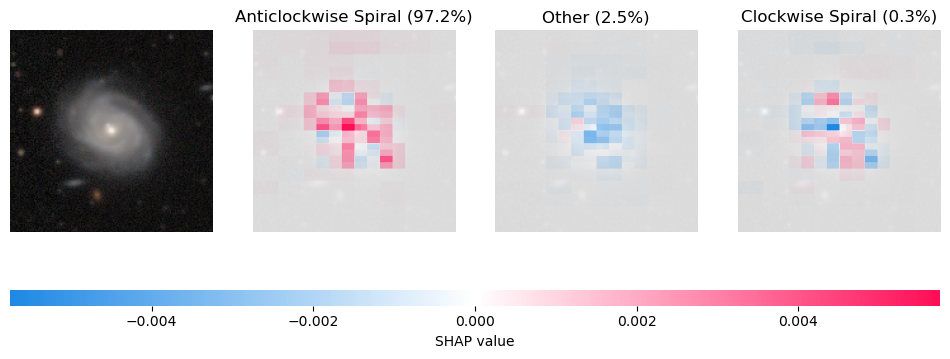

In [10]:
generate_shap_plot(505)

Partition explainer: 2it [04:48, 288.03s/it]              


<Figure size 600x1000 with 0 Axes>

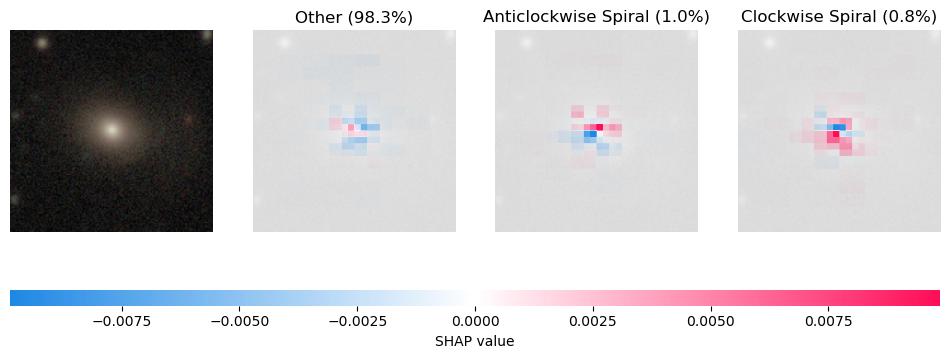

In [11]:
generate_shap_plot(1002)

In [28]:
# #Dereference all objects, clear cuda cache and run garbage collection
# datamodule=None
# model=None
# trainer=None
# with torch.no_grad():
#     torch.cuda.empty_cache()
# gc.collect()

In [34]:
custom_albumentation_transform=generate_transforms(resize_after_crop=IMG_SIZE,random_rotate=False)

def do_transform(img, transforms_to_apply):
    return np.transpose(transforms_to_apply(image=np.array(img))["image"], axes=[2, 0, 1]).astype(np.float32)

def generate_shap_plot_from_jpg(file_name,max_evals=100):
    X = Image.open(file_name, mode='r')
    X.load()

    X = do_transform(X,custom_albumentation_transform) 
    X = torch.Tensor(X).unsqueeze(0)

    Xtr = nchw_to_nhwc(X) #This is in format nhwc

    prediction = torch.softmax(model(X),dim=1).detach().numpy()[0]
    class_names = [f'Clockwise Spiral ({prediction[0]:.1%})',f'Anticlockwise Spiral ({prediction[1]:.1%})',f'Other ({prediction[2]:.1%})']

    def pass_to_model(x):
        #This takes input in format nhwc
        x = torch.Tensor(x)
        if x.shape == [160, 160,3]: #Add n if missing
            x = x.unsqueeze(0)
        x = nhwc_to_nchw(x)
        return model(x) #Model takes nchw
    
    masker = shap.maskers.Image(f"blur({Xtr[0].shape[0]},{Xtr[0].shape[1]})",Xtr[0].shape)
    explainer = shap.Explainer(pass_to_model, masker, output_names=class_names)
    shap_values = explainer(Xtr[0:1], max_evals=max_evals, batch_size=BATCH_SIZE, outputs=shap.Explanation.argsort.flip[:3])
    shap_values.data = shap_values.data.cpu().numpy()
    plt.figure(figsize=(6,10))
    shap.image_plot(shap_values,show=False)
    #plt.savefig(f"{PREDICT_DATASET.name.lower()}_{image_index}_shap.png")
    plt.show()

Partition explainer: 2it [04:16, 256.68s/it]              


<Figure size 600x1000 with 0 Axes>

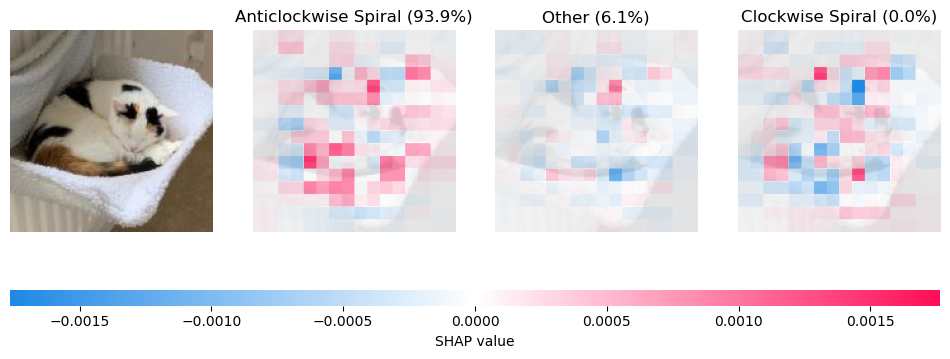

In [41]:
generate_shap_plot_from_jpg('test_images/natcat2.jpg',10000)

Partition explainer: 2it [04:55, 295.06s/it]              


<Figure size 600x1000 with 0 Axes>

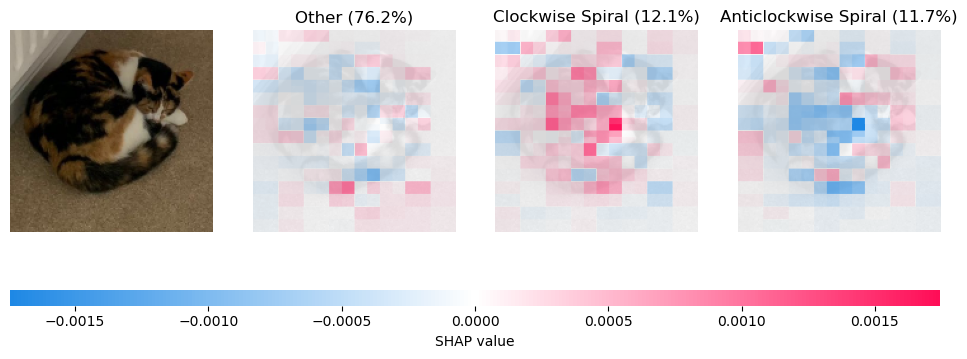

In [44]:
generate_shap_plot_from_jpg('test_images/natcat1.jpg',10000)

Partition explainer: 2it [05:24, 324.58s/it]              


<Figure size 600x1000 with 0 Axes>

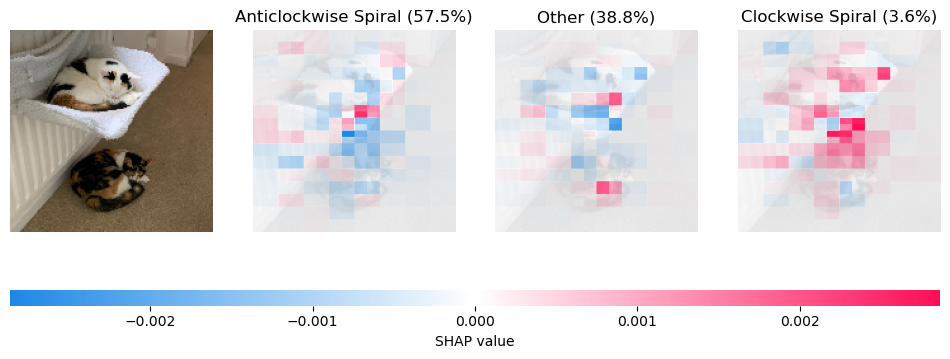

In [42]:
generate_shap_plot_from_jpg('test_images/natcat.jpg',10000)